In [4]:
import numpy as np
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import express as px
import plotly.graph_objs as go
from dash import Dash, html, Input, Output, Patch, dash_table
import dash_leaflet as dl
import json
from dash import Dash, dcc, html, dash_table, Input, Output, State, callback, no_update
import base64
import datetime
from datetime import date, datetime, timedelta
import io
from flask import Flask, jsonify
import asyncio
from threading import Thread

## NASA API

- access to current weather information for any location
- intended to predict accident severity with current weather conditions and machine learning model

In [5]:
# NASA API
def get_nasa_power_data(lat, lon, start_date, end_date, for_graph=False):
    """
    Fetches NASA POWER API data for given latitude, longitude, and time range.

    Args:
    - lat (float): Latitude of the location.
    - lon (float): Longitude of the location.
    - start_date (str): Start date in YYYYMMDD format.
    - end_date (str): End date in YYYYMMDD format.

    Returns:
    - Pandas DataFrame with selected weather parameters.
    """

    # Specify multiple parameters in the API request
    parameters = "PRECSNO,T2MDEW,PRECTOTCORR,T2M,WS2M,RH2M,CLOUD_AMT"

    url = "https://power.larc.nasa.gov/api/temporal/daily/point"
    params = {
        "parameters": parameters,
        "community": "RE",
        "longitude": lon,
        "latitude": lat,
        "start": start_date,
        "end": end_date,
        "format": "JSON"
    }

    response = requests.get(url, params=params)

    data = response.json()

    # Convert JSON response to DataFrame and transpose it
    nasa_weather = pd.DataFrame.from_dict(data["properties"]["parameter"], orient="index").T

    # Reset index and rename date column
    nasa_weather.reset_index(inplace=True)
    nasa_weather.rename(columns={"index": "date"}, inplace=True)

    # Convert date column to proper datetime format
    nasa_weather["date"] = pd.to_datetime(nasa_weather["date"], format="%Y%m%d", errors="coerce")
    nasa_weather.dropna(subset=["date"], inplace=True)  # Remove invalid date rows

    nasa_weather.rename(columns={
        "PRECSNO": "Snow_Precipitation",
        "T2MDEW": "Dew_Point_2m",
        "PRECTOTCORR": "Total_Precipitation_mm",
        "T2M": "Temperature_2m_C",
        "WS2M": "Wind_Speed_2m",
        # new cols
        "RH2M": "Relative Humidity (%)",
        "CLOUD_AMT" : "Cloud Cover (%)",
    }, inplace=True)
    
    # Add Rounded_Lat and Rounded_Lng for merging
    nasa_weather['Rounded_Lat'] = lat
    nasa_weather['Rounded_Lng'] = lon
    
    nasa_weather['Precipitation (in)'] = nasa_weather['Total_Precipitation_mm'] / 25.4 # mm to in
    nasa_weather['Temperature (F)'] = (nasa_weather['Temperature_2m_C'] * (9./5.)) + 32. # C to F
    nasa_weather['Wind Speed (mph)'] = nasa_weather['Wind_Speed_2m'] * 2.237 # m/s to mph

    if for_graph:
        nasa_weather = nasa_weather[["Precipitation (in)","Temperature (F)","Wind Speed (mph)","Relative Humidity (%)","Cloud Cover (%)"]]

    return nasa_weather

## Interactive Weather App (in progress)

In [54]:
app = Dash()
app.layout = html.Div([
    dcc.Tabs([
        dcc.Tab(label='Current Weather', children=[
            dcc.Markdown('''
                ## Directions: 
                1. Pan and zoom in/out on the map to find your location.
                2. Click your location on the map for current weather.
                    Press the "Submit" button to confirm your selection and your weather reuslts will load promptly.
                3. Check out the "Weather Graphs" and "Weather Predictions" tabs for more weather information.'''),
            dcc.Markdown('''## Select Location:'''),
            dl.Map( # add zoom to city buttons?
                id='map',
                n_clicks=0,
                children=[
                    dl.TileLayer()
                ],
                center=[34, -118],
                zoom=9,
                style={'height': '50vh'}
            ),
            html.Div(id='coords'),
            html.Button('Submit',id='submit',n_clicks=0), 
            dcc.Markdown('## Current Weather:'),
            dash_table.DataTable(id='weather',
                style_as_list_view=True,
                style_cell={'padding': '2px'},
                style_header={
                    'backgroundColor': 'white',
                    'fontWeight': 'bold'
                },
                style_cell_conditional=[
                    {'textAlign': 'center'}
                ],
            ),
            dcc.Store(id='latitude'),
            dcc.Store(id='longitude'),
            dcc.Store(id='date'),
        ]),
        
        dcc.Tab(label='Weather Graphs', children=[
            dcc.Markdown('''
                ## Directions: 
                1. Select a weather attribute you are interested in.
                2. Select the type of graph you wish to see.
                3. Click the "Create Graph" button to confirm your choice. 
                    Your graph will load promptly with weather information from your previously selected location.'''),
            dcc.Markdown("### Select an Attribute:"),
            dcc.Dropdown(visual_options,id='options'),
            dcc.Markdown("### Select a Graph:"),
            dcc.Dropdown(graph_options,id='graph_type'),
            html.Button('Create Graph', id='submit-graph', n_clicks=0),
            dcc.Markdown(id='caption'),
            dcc.Graph(id='visual'),
        ]),
        
        dcc.Tab(label='Weather Predictions', children=[
            dcc.Markdown('''
                ## Directions: 
                1. Select a weather attribute you are interested in.
                2. Select the number of days into the future you want to be predicted.
                3. Click the "Predict Weather" button to confirm your choice. 
                    Your graph will load promptly with weather information from your previously selected location.'''),
            dcc.Markdown("### Select an Attribute:"),
            dcc.Dropdown(visual_options,id='target'),
            dcc.Markdown("### Select the Number of Days to Predict:"),
            dcc.Dropdown(n_days, id='n_future'),
            # dcc.Dropdown(n_past, id='n_past'),
            html.Button('Predict Weather', id='predict-weather', n_clicks=0),
            dcc.Markdown(id='pred-caption'),
            # dash_table.DataTable(id='pred-table',
            #     style_as_list_view=True,
            #     style_cell={'padding': '2px'},
            #     style_header={
            #         'backgroundColor': 'white',
            #         'fontWeight': 'bold'
            #     },
            #     style_cell_conditional=[
            #         {'textAlign': 'center'}
            #     ],
            # ),
            dcc.Graph(id='pred-graph'),
        ])
    ])
])
    
# TAB 1 - CURRENT WEATHER ---------------------------------------------------------------------------------
@app.callback(
    Output('coords', 'children'),
    Output('map', 'children'),
    Output('latitude','data'),
    Output('longitude','data'),
    Output('date','data'),
    Input('map', 'clickData'),
    Input('map', 'n_clicks'),
    prevent_initial_call=True
)
def map(click_data, n_clicks):
    if n_clicks > 0:
        coordinates = click_data['latlng']
        latitude, longitude = coordinates.values()
        # create Patch() instance, add Marker layer at click coordinates
        patched = Patch()
        # patched=(dl.Marker(position=[latitude,longitude]))
        patched.append(dl.Marker(position=[latitude, longitude]))
        today = date.today().strftime('%Y%m%d')
        n_clicks=0
        return json.dumps(coordinates), patched, latitude, longitude, today
    
@app.callback(
    Output('weather','data'),
    Output('weather','columns'),
    Input('submit','n_clicks'),
    State('latitude','data'),
    State('longitude','data'),
    State('date','data'),
    prevent_initial_call=True,
)
def submit(n_clicks, lat, lng, current_date):
    if n_clicks > 0:
        if(lat == None or lng == None):
            return '##### Please select a location.'
        df = get_nasa_power_data(lat, lng, current_date, current_date, for_graph=True)
        cols = [{'name': col, 'id': col} for col in df.columns]
        weather_df = df.to_dict('records')
        return weather_df, cols
        
# TAB 2 - WEATHER GRAPHS ---------------------------------------------------------------------------------
@app.callback(
    Output('visual','figure'),
    Output('caption','children'),
    Input('submit-graph','n_clicks'),
    State('options','value'),
    State('graph_type','value'),
    State('latitude','data'),
    State('longitude','data'),
    State('date','data'),
    prevent_initial_call=True,
)
def create_graph(n_clicks, attr, graph_type, lat, lng, day):
    if n_clicks > 0:
        today = date.today().strftime("%m-%d-%Y")
        caption = f" **{attr}** graph for **{today}** at **({round(lat,2)}, {round(lng,2)})**."
        loop = asyncio.new_event_loop()
        graph = loop.run_until_complete(choose_graph(attr, graph_type, lat, lng, day))
        return graph, caption

    
# TAB 3 - WEATHER PREDICTIONS ---------------------------------------------------------------------------------
@app.callback(
    Output('pred-caption','children'),
    Output('pred-graph','figure'),
    # Output('pred-table','data'),
    Input('predict-weather','n_clicks'),
    State('target','value'),
    State('n_future','value'),
    # State('n_past','n_past'),
    State('latitude','data'),
    State('longitude','data'),
    State('date','data'),
    prevent_initial_call=True,
)
def get_predictions(n_clicks, attr, n_future, lat, lng, date):
    if n_clicks > 0:
        caption = f" **{attr}** predictions at **({round(lat,2)}, {round(lng,2)})**."
        dataset = get_nasa_power_data(lat, lng, "20220620", "20230621")
        real, predicted = run_model(dataset, attr, 50, n_future)
        graph = plot_predictions(attr, real, predicted, n_future)
        return caption, graph

if __name__ == '__main__':
    app.run(port=1320,debug=True)

Epoch 1/20


C:\Users\littl\anaconda3\envs\PIC16B-25W\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - acc: 0.2349 - loss: 0.1387
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - acc: 0.3850 - loss: 0.0294
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - acc: 0.3817 - loss: 0.0214
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - acc: 0.2776 - loss: 0.0179
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - acc: 0.4038 - loss: 0.0163
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - acc: 0.3072 - loss: 0.0201
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - acc: 0.2768 - loss: 0.0163
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - acc: 0.2921 - loss: 0.0165
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - acc: 0.3594 - loss: 0.0183
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - acc: 0.3312 - loss: 0.0144
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - acc: 0.3075 - loss: 0.0150
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - acc: 0.3278 - loss: 0.0128
Epoch 13/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/

In [6]:
visual_options = ["Temperature (F)", "Precipitation (in)", "Wind Speed (mph)", "Relative Humidity (%)", "Cloud Cover (%)"]
graph_options = ["Hourly Change", "Yearly Change", "Local Trends"]

async def choose_graph(attr, graph_type, lat, lng, day):
    
    start_year = (date.today() - timedelta(days=1825)).strftime('%Y')
    yesterday = (date.today() - timedelta(days=1)).strftime('%Y%m%d')
    
    if graph_type == "Hourly Change":
        hour_df = await get_nasa_power_hourly_data(lat, lng, day)
        return plot_hourly(hour_df,attr)
        
    elif graph_type == "Yearly Change":
        year_df = await get_nasa_power_hourly_data_years(lat, lng, 2014, 2024)
        return plot_yearly(year_df,attr)

    else: 
        return plot_heatmap(attr, lat, lng, day, num_locations=50)

## Complex Visualizations Functions

In [7]:
import numpy as np
import aiohttp
import asyncio
import pandas as pd
import nest_asyncio
import plotly.express as px
from datetime import datetime

# Apply nest_asyncio for async execution 
nest_asyncio.apply()

async def fetch_nasa_data(session, lat, lon, start_date, end_date, sem):
    """
    Fetches hourly weather data from the NASA POWER API asynchronously for a given location and time range.
    """
    url = "https://power.larc.nasa.gov/api/temporal/hourly/point"
    parameters = "PRECSNO,T2MDEW,PRECTOTCORR,T2M,WS2M,RH2M,CLOUD_AMT"

    params = {
        "parameters": parameters,
        "community": "RE",
        "longitude": lon,
        "latitude": lat,
        "start": start_date,
        "end": end_date,
        "format": "JSON"
    }

    async with sem:  
        async with session.get(url, params=params) as response:
            if response.status != 200:
                print(f"Error {response.status} for {lat}, {lon}, {start_date}-{end_date}")
                return None
            return await response.json()  

async def get_nasa_power_hourly_data(lat, lon, date=None):
    """
    Fetches NASA POWER hourly weather data for a single day (default behavior).
    """
    if date is None:
        date = datetime.now().strftime("%Y%m%d")

    sem = asyncio.Semaphore(5)
    async with aiohttp.ClientSession() as session:
        data = await fetch_nasa_data(session, lat, lon, date, date, sem)

    if data is None or "properties" not in data:
        print(f"No data found for {lat}, {lon} on {date}")
        return None

    df = pd.DataFrame.from_dict(data["properties"]["parameter"], orient="index").T
    df.reset_index(inplace=True)
    df.rename(columns={"index": "datetime"}, inplace=True)
    
    # Convert datetime and clean up
    df["datetime"] = pd.to_datetime(df["datetime"], format="%Y%m%d%H", errors="coerce")
    df.dropna(subset=["datetime"], inplace=True)
    
    # Rename columns
    df.rename(columns={
        "PRECSNO": "Snow_Precipitation",
        "T2MDEW": "Dew_Point_2m",
        "PRECTOTCORR": "Total_Precipitation_mm",
        "T2M": "Temperature_2m_C",
        "WS2M": "Wind_Speed_2m",
        "RH2M": "Relative Humidity (%)",
        "CLOUD_AMT" : "Cloud Cover (%)",
    }, inplace=True)

    # Add Lat/Lon
    df["Latitude"] = lat
    df["Longitude"] = lon

    # Convert units
    df["Precipitation (in)"] = df["Total_Precipitation_mm"] / 25.4  
    df["Temperature (F)"] = (df["Temperature_2m_C"] * 9/5) + 32  
    df["Wind Speed (mph)"] = df["Wind_Speed_2m"] * 2.237  

    return df

async def get_nasa_power_hourly_data_years(lat, lon, start_year, end_year):
    """
    Fetches NASA POWER API hourly data for multiple years in 2-year chunks to prevent timeouts.
    """
    tasks = []
    
    for year in range(start_year, end_year):  
        start_date = f"{year}0101"
        end_date = f"{min(year, end_year)}1231"
        # print(f"Fetching data from {start_date} to {end_date} for {lat}, {lon}")
        tasks.append(get_nasa_power_hourly_data(lat, lon, start_date))

    results = await asyncio.gather(*tasks)

    all_data = [df for df in results if df is not None]

    return pd.concat(all_data, ignore_index=True) if all_data else None



In [8]:
attr_colors = {"Temperature (F)": "red", 
         "Precipitation (in)":"blue", 
         "Wind Speed (mph)":"green", 
         "Relative Humidity (%)":"teal", 
         "Cloud Cover (%)":"grey"}

def plot_hourly(df, attr):
    fig = px.line(df, x="datetime", y=attr, title=f"Hourly {attr} Trends",
                  labels={"datetime": "Datetime"},
                  line_shape='linear', color_discrete_sequence=[attr_colors[attr]])
    fig.update_layout(xaxis_title="Datetime", yaxis_title=attr, xaxis_tickangle=-45)
    return fig

In [9]:
def plot_yearly(df,attr):
    df["year"] = df["datetime"].dt.year
    yearly_means = df.groupby("year")[attr].mean().reset_index()
    fig = px.bar(yearly_means,
                 x="year",
                 y=attr,
                 color_discrete_sequence=[attr_colors[attr]],
                 title=f"Yearly Average {attr} Trends",
                 labels={"year": "Year"})
    return fig


In [10]:
def generate_nearby_locations(lat, lon, radius_miles=15, num_points=10):
    """
    Generates random nearby locations within a radius using NumPy.

    Args:
    - lat (float): Latitude of the center point.
    - lon (float): Longitude of the center point.
    - radius_miles (float): Search radius in miles.
    - num_points (int): Number of locations to generate.

    Returns:
    - NumPy array of shape (num_points, 2) with latitude and longitude values.
    """
    # Generate random angles uniformly between 0 and 2π
    angles = np.random.uniform(0, 2 * np.pi, num_points)

    # Use square root scaling to distribute points uniformly across the circle
    distances = radius_miles * np.sqrt(np.random.uniform(0, 1, num_points))

    # Convert polar coordinates (distance, angle) to latitude & longitude offsets
    delta_lat = (distances / 69) * np.cos(angles)
    delta_lon = (distances / (69 * np.cos(np.radians(lat)))) * np.sin(angles)

    # Compute new latitudes and longitudes
    new_lat = lat + delta_lat
    new_lon = lon + delta_lon

    return np.column_stack((new_lat, new_lon))

In [11]:
async def get_nasa_power_data_for_nearby_locations(lat, lon, start_year, end_year, num_locations=10, radius_miles=15):
    """
    Fetches NASA POWER API hourly data for multiple nearby locations over a multi-year period.
    Data is retrieved in 2-year intervals to avoid timeouts.

    Args:
        lat (float): Latitude of the central location.
        lon (float): Longitude of the central location.
        start_year (int): Start year of the data collection.
        end_year (int): End year of the data collection.
        num_locations (int, optional): Number of nearby locations to generate. Default is 10.
        radius_miles (float, optional): Radius in miles to generate nearby locations. Default is 15.

    Returns:
        pd.DataFrame or None: A Pandas DataFrame containing weather data for all locations and years, or None if no data is retrieved.
    """
    locations = generate_nearby_locations(lat, lon, radius_miles, num_locations)
    tasks = []

    for year in range(start_year, end_year, 2):  
        print(f"Fetching data for {year}-{year+1} at {num_locations} locations...")
        for location in locations:
            tasks.append(get_nasa_power_hourly_data_ten_years(location[0], location[1], year, year + 2))

    results = await asyncio.gather(*tasks)  

    all_data = [df for df in results if df is not None]

    return pd.concat(all_data, ignore_index=True) if all_data else None

async def get_nasa_power_data_for_one_day_nearby(lat, lon, date=None, num_locations=10, radius_miles=15):
    """
    Fetches NASA POWER API hourly data for multiple nearby locations for a single day.

    Args:
        lat (float): Latitude of the central location.
        lon (float): Longitude of the central location.
        date (str, optional): Date in "YYYYMMDD" format. Defaults to today.
        num_locations (int, optional): Number of nearby locations to generate. Default is 10.
        radius_miles (float, optional): Radius in miles to generate nearby locations. Default is 15.

    Returns:
        pd.DataFrame or None: A Pandas DataFrame containing weather data for all locations, or None if no data is retrieved.
    """
    if date is None:
        date = datetime.now().strftime("%Y%m%d")

    locations = generate_nearby_locations(lat, lon, radius_miles, num_locations)
    tasks = [get_nasa_power_hourly_data(location[0], location[1], date) for location in locations]

    results = await asyncio.gather(*tasks)

    all_data = [df for df in results if df is not None]

    return pd.concat(all_data, ignore_index=True) if all_data else None


In [12]:
def plot_heatmap(attr, lat, lon, date=None, num_locations=50, radius_miles=15):
    """
    Fetches weather data for locations in a radius and plots temperature & precipitation heat maps
    with a square-shaped view.
    """
    locations = generate_nearby_locations(lat, lon, radius_miles, num_locations)
    
    # Fetch weather data
    weather_data = asyncio.run(get_nasa_power_data_for_one_day_nearby(lat, lon, date, num_locations, radius_miles))
    if weather_data is None or weather_data.empty:
        print("No data retrieved.")
        return

    # Force a square bounding box
    lat_margin = radius_miles / 69  # 1 degree latitude ≈ 69 miles
    lon_margin = radius_miles / (69 * np.cos(np.radians(lat)))  # Adjust for longitude shrinking

    min_lat, max_lat = lat - lat_margin, lat + lat_margin
    min_lon, max_lon = lon - lon_margin, lon + lon_margin
  
    fig_temp = px.scatter_mapbox(
        weather_data, lat="Latitude", lon="Longitude", color=attr,
        title=f"{attr} in Nearby Locations"
    )
    fig_temp.update_layout(
        mapbox_style="carto-positron",
        autosize=True 
    )

    return fig_temp


# Keras Model to Predict Upcoming Weather

In [13]:
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
#from keras import layers, losses
from keras.models import Sequential
from keras.layers import LSTM, Dense,Dropout, Bidirectional
from sklearn.preprocessing import MinMaxScaler
import datetime
import requests
"""
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.layers.recurrent import LSTM
"""
import matplotlib.pyplot as plt
from plotly import express as px
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import preprocessing, tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [51]:
# Function that takes a feature, and runs a model to predict the next 4 days of that feature based on 30 days of previous weather
def run_model(dataset, feature, n_past=50, n_future=7):
    feature = feature
    dataset = dataset.dropna(subset=[feature])
    dataset = dataset.reset_index(drop=True)
    training_set = dataset[[feature]].values

    sc = MinMaxScaler(feature_range=(0,1))
    training_set_scaled = sc.fit_transform(training_set)

    x_train = []
    y_train = []

    n_past = n_past # Number of days to use as training data
    n_future = n_future # Number of days into future to predict feature

    for i in range(0,len(training_set_scaled)-n_past-n_future+1):
        x_train.append(training_set_scaled[i : i + n_past , 0])
        y_train.append(training_set_scaled[i + n_past : i + n_past + n_future , 0 ])
    x_train , y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0] , x_train.shape[1], 1) )

    model = Sequential([
        Bidirectional(LSTM(units=n_past, return_sequences=True, input_shape=(x_train.shape[1], 1))),
        Dropout(0.2),
        LSTM(units=n_past, return_sequences=True),
        Dropout(0.2),
        LSTM(units=n_past, return_sequences=True),
        Dropout(0.2),
        LSTM(units=n_past),
        Dropout(0.2),
        Dense(units=n_future, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['acc'])
    model.fit(x_train, y_train, epochs=20, batch_size=32)

    testdataset = dataset.copy()
    testdataset = testdataset[[feature]].iloc[:n_past].values
    # return n_past most recent temperatures 
    real_temperature = dataset.copy().sort_values("date", ascending=False).iloc[-n_past:-1]
    real_temperature = real_temperature[["date",feature]]
    # real_temperature = real_temperature[["date",feature]].sort_values("date", ascending=False).iloc[-n_past:-1].values
    testing = sc.transform(testdataset)
    testing = np.array(testing)
    testing = np.reshape(testing,(testing.shape[1],testing.shape[0],1))

    predicted_temperature = model.predict(testing)
    predicted_temperature = sc.inverse_transform(predicted_temperature)
    predicted_temperature = np.reshape(predicted_temperature,(predicted_temperature.shape[1],predicted_temperature.shape[0]))
    return real_temperature, predicted_temperature

# real_temperature, predicted_temperature = run_model(dataset2, "Temperature(F)", 300, 30)

In [52]:
from datetime import date, datetime, timedelta
import plotly.express as px

# list for dropdown menu
n_days = [3,5,10,20,30]

def plot_predictions(attr, real, predicted, n_future):
    real["Label"] = "Real"
    new_dates = [real["date"].iloc[0] + timedelta(days=x) for x in range(1,n_future+1)]
    new_rows = pd.DataFrame({"date": new_dates,
                             attr: predicted.flatten(), 
                             "Label": "Predicted"})
    df = pd.concat([real, new_rows], ignore_index=True)
    fig = px.line(df,x="date",y=attr,color="Label")
    return fig

Epoch 1/20


C:\Users\littl\anaconda3\envs\PIC16B-25W\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - acc: 0.0240 - loss: 0.1661
Epoch 2/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - acc: 0.0260 - loss: 0.0939
Epoch 3/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - acc: 0.0527 - loss: 0.0519
Epoch 4/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - acc: 0.0273 - loss: 0.0406
Epoch 5/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - acc: 0.0279 - loss: 0.0350
Epoch 6/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - acc: 0.0172 - loss: 0.0304
Epoch 7/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - acc: 0.0404 - loss: 0.0306
Epoch 8/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - acc: 0.0435 - loss: 0.0262
Epoch 9/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - acc: 0.0329 - loss: 0.0247
Epoch 10/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - acc: 0.0351 - loss: 0.0242
Epoch 11/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - acc: 0.0581 - loss: 0.0242
Epoch 12/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - acc: 0.0416 - loss: 0.0224
Epoch 13/20
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - acc: 0.0544 - loss: 

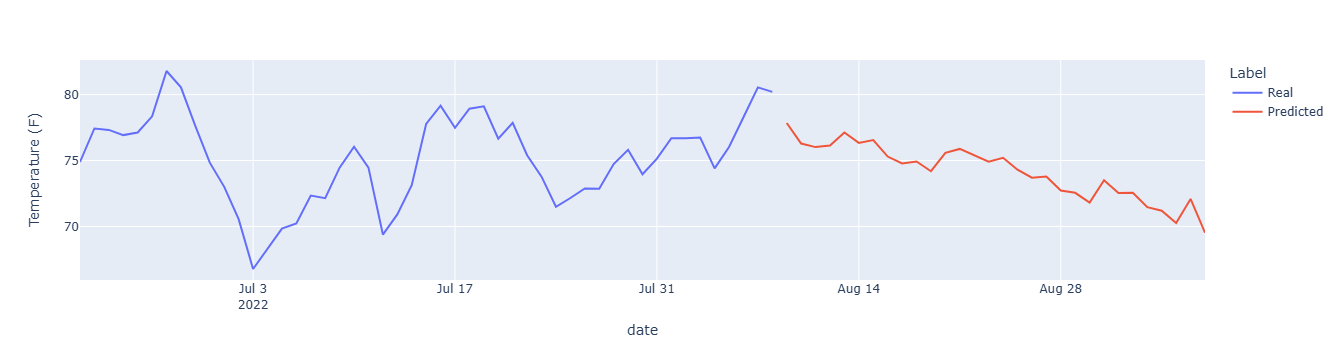

In [46]:
dataset2 = get_nasa_power_data(34.05, -118.25, "20220620", "20230621")
real_temperature, predicted_temperature = run_model(dataset2, "Temperature (F)", 50, 30)
graph = plot_predictions("Temperature (F)", real_temperature, predicted_temperature, 30)
graph.show()